In [1]:
#reading dataset
import pandas as pd

#group multiple files
import glob

#word2vec
import gensim.models.word2vec as w2v

#concurrency
import multiprocessing

#dealing with operating system , like reading file
import os

#dimensionality reduction
import sklearn.manifold

#visualization
import seaborn as sns

import random

In [2]:
file_names = sorted(glob.glob('data/*.csv'))

In [3]:
#Copy all words (tags) describing various objects into a new big array 'sentences'.

sentences = []
total_words = 0

for file_name in file_names:
    df = pd.read_csv(file_name)
    
    num_of_words = 0

    for index, row in df.iterrows():
        
        sentence = row[2].lower().split(';')
        sentences.append(sentence)
        
        num_of_words += len(sentence)

    total_words += num_of_words
    
print('TOTAL ' + str(total_words) + ' words')

TOTAL 160015 words


In [4]:
#Dimensionality of the resulting word vectors
#more dimensions means more training time, but more generalized
num_features = 300

#Minimum word count threshold.
min_word_count = 3

#Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()

#Context window length.
context_size = 7

#Downsample setting for frequent words.
#Rate: 0 to 1e-5 (How often to use?)
downsampling = 1e-3

#Seed for the RNG, to make the results reproducible.
seed = 1

In [5]:
text2vec = w2v.Word2Vec(
    sg = 1,
    seed = seed,
    workers = num_workers,
    size = num_features,
    min_count = min_word_count,
    window = context_size,
    sample = downsampling
)

In [6]:
text2vec.build_vocab(sentences)

In [7]:
print('text2vec vocabulary length: ' + str(len(text2vec.wv.vocab)))

text2vec vocabulary length: 557


In [8]:
#train model on sentneces
text2vec.train(sentences, total_examples = text2vec.corpus_count, epochs = text2vec.iter)

/Users/Sailesh/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


(482881, 800075)

In [9]:
#save model
if not os.path.exists("trained"):
    os.makedirs("trained")

text2vec.save(os.path.join("trained", "text2vec.w2v"))

In [10]:
#squash dimensionality to 2
#https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [11]:
#put it all into a giant matrix
all_word_vectors_matrix = text2vec.wv.vectors

In [12]:
#train t sne (takes time if it's a huge dataset to train)
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [13]:
#plot points in 2d space
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[text2vec.wv.vocab[word].index])
            for word in text2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

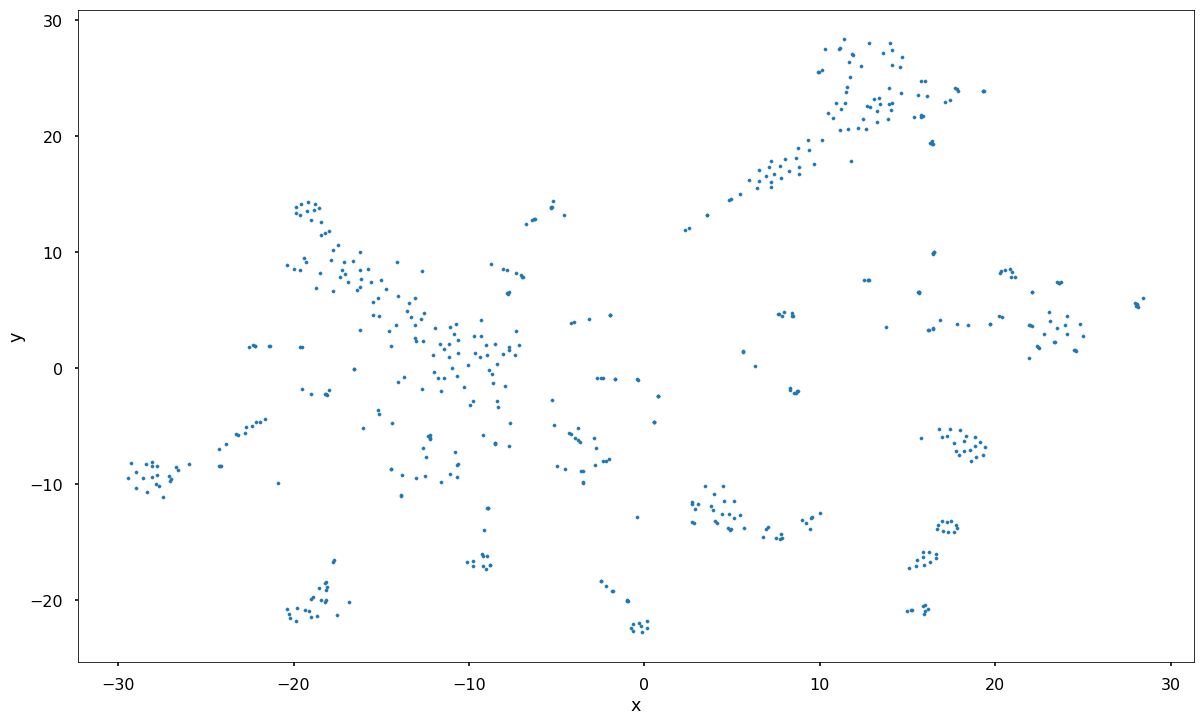

In [14]:
sns.set_context("poster")

#plot
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [15]:
#Processing the input_sentence

#split sentence into a list of words and remove unwanted words

def sentence_to_wordlist(sentence):
    words = sentence.split(' ')
    words = [word.lower() for word in words]
        
    unwanted_words = set(['also', 'on', 'side', 'one', 'them', 'which', 'around', 'in', 'at', 'of', 'with', 'besides', 'only', 'kept', 'was', 'been', 'had', 'he', 'she', 'my', 'his', 'her', 'their', 'those', 'as', 'our', 'there', 'are', 'is', 'a', 'and', 'placed', 'the', 'has', 'having', 'it', 'this', 'that', 'just', 'which', 'have', 'where', 'they'])

    words_list = [word for word in words if word not in unwanted_words]
            
    return words_list

In [16]:
input_sentence = 'there are 2 chair in the front 1 at the '

In [109]:
words = sentence_to_wordlist(input_sentence)
print(words)

object_num = []
object_pos = []

pos = {'left':-1, 'right':-2, 'front':-3, 'back':-4, 'default':-5, 'above':-6}

i = 0
n = 1
while i < len(words):
    
    if (ord(words[i][0]) > 48 and ord(words[i][0]) < 58):
        n = int(words[i])
        object_num.append(n)
        
        if (i+2 < len(words) and words[i+2] not in pos):
            if (n == 1):
                object_pos.append(pos['back'])
            elif (n == 2):
                object_pos.append(pos['left'])
                object_pos.append(pos['right'])
            elif (n == 3):
                object_pos.append(pos['left'])
                object_pos.append(pos['right'])
                object_pos.append(pos['back'])
            elif (n == 4):
                object_pos.append(pos['front'])
                object_pos.append(pos['left'])
                object_pos.append(pos['right'])
                object_pos.append(pos['back'])
        elif (i+2 < len(words)):
            for j in range(n):
                object_pos.append(pos[words[i+2]])
        i += 1
        
    elif words[i] in text2vec.wv.vocab:
        object_num.append(1)
        if (i+1 < len(words) and words[i+1] in pos):
            object_pos.append(pos[words[i+1]])
        else:
            object_pos.append(pos['default'])
    
    i += 1
    
print(object_num)
print(object_pos)

['chair', 'above', 'table']
[1, 1]
[-6, -5]


In [110]:
words_list = [text2vec.wv.most_similar(word)[random.randrange(0,5)][0] for word in words if word in text2vec.wv.vocab]
words_list

['no. 14 chair', 'work table']

In [111]:
#search for the id of object; you have the tag.

def retrive_object_paths(words_list):
    file_names = sorted(glob.glob('data/*.csv'))
    object_paths = []
    
    for word in words_list:
        ids = []
        folders = []

        for file_name in file_names:
            df = pd.read_csv(file_name)

            for index, row in df.iterrows():
                sentence = row[2].lower().split(';')

                if (word in sentence and row[0] not in ids):
                    ids.append(row[0])
                    folders.append(row[1])

        print('\n' + word + ' ------ ' + str(len(ids)) + ' images')
        
        x = random.randrange(0, len(ids))

        id = ids[x][4:]
        folder = folders[x]
        path = '/Users/Sailesh/Documents/CS/Projects/CDSAML/text2scene/ShapeNetCore.v1/'+ folder + '/' + id + '/model.obj'
        
        if(';' in folder):
            folder_list = folder.split(';')
            for folder in folder_list:
                path = '/Users/Sailesh/Documents/CS/Projects/CDSAML/text2scene/ShapeNetCore.v1/'+ folder + '/' + id + '/model.obj'
                if os.path.exists(path):
                    break

        print('choosing 1 at random...')
        print('PATH: ' + path)
        
        object_paths.append(path)
        
    return object_paths

In [112]:
paths = retrive_object_paths(words_list)


no. 14 chair ------ 11 images
choosing 1 at random...
PATH: /Users/Sailesh/Documents/CS/Projects/CDSAML/text2scene/ShapeNetCore.v1/03001627/6921b41c2f6916e2bea04b36c2ada3a3/model.obj

work table ------ 303 images
choosing 1 at random...
PATH: /Users/Sailesh/Documents/CS/Projects/CDSAML/text2scene/ShapeNetCore.v1/04379243/b8ffc016a4e080a6d2e5fdcf2bc010e2/model.obj


In [113]:
#save all in a new file

f = open("object_path.txt","w")

k = 0
for i in range(len(paths)):
    f.write(paths[i] + '\n')
    f.write(str(object_num[i]) + '\n')
    for j in range(object_num[i]):
        f.write(str(object_pos[j+k]) + '\n')
    k += j+1
    
f.close()

In [ ]:
#open blender through terminal by using subprocess
import subprocess
subprocess.call('/Applications/Blender/blender.app/Contents/MacOS/blender --python3 blender.py', cwd='/Users/Sailesh/Documents/CDSAML/text2image', shell=True)